# File 4 **Model Training and Evaluation**

## 1. Load the 'dataset_preprocessed_v1.csv' file

In [47]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
import numpy as np
import pandas as pd

# Load the prepared dataset
dataset_cleaned = pd.read_csv('dataset_preprocessed_v1.csv', index_col=0)

## 2. Check data types

* Check data dtypes to see if there is any feature which is not ready for Machine Learning models

In [48]:
# Check data types of all features
print("Data Types:")
print(dataset_cleaned.dtypes.value_counts())

# Find non-numerical columns
non_numerical_cols = dataset_cleaned.select_dtypes(exclude=['int64', 'float64', 'bool']).columns
print("\nNon-Numerical Columns:")
print(non_numerical_cols)

# Sample values from non-numerical columns to inspect
if not non_numerical_cols.empty:
    print("\nSample values from non-numerical columns:")
    for col in non_numerical_cols:
        print(f"\nColumn: {col}")
        print(dataset_cleaned[col].unique()[:10])  # Display a few unique values

Data Types:
bool       4746
int64       205
float64       5
Name: count, dtype: int64

Non-Numerical Columns:
Index([], dtype='object')


## 3.Split Data Train-Validation-Test

In [49]:
from sklearn.model_selection import train_test_split

# Define features (X) and targets (y)
X = dataset_cleaned.drop(columns=['metascore', 'userscore'])
y_metascore = dataset_cleaned['metascore'] 
y_userscore = dataset_cleaned['userscore']

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train_meta, y_test_meta, y_train_user, y_test_user = train_test_split(
    X, y_metascore, y_userscore, test_size=0.2, random_state=42)

# Validate the split
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"y_train_meta shape: {y_train_meta.shape}, y_test_meta shape: {y_test_meta.shape}")
print(f"y_train_user shape: {y_train_user.shape}, y_test_user shape: {y_test_user.shape}")

X_train shape: (9329, 4954), X_test shape: (2333, 4954)
y_train_meta shape: (9329,), y_test_meta shape: (2333,)
y_train_user shape: (9329,), y_test_user shape: (2333,)


## 4. Ridge Regression (Baseline Model)

* GridSearch and Model Evaluation

In [50]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np

# Define the expanded parameter grid for Ridge Regression
ridge_param_grid = {
    'ridge__alpha': [1, 10, 50, 100, 500, 1000]
}

# Function to perform Ridge Regression GridSearch and evaluation
def perform_ridge_grid_search_with_cv(model, param_grid, X_train, y_train, X_test, y_test, target_name):
    print(f"\nRunning GridSearch for Ridge Regression ({target_name})...")
    
    # Create a pipeline with standardization
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('ridge', model)
    ])
    
    # Perform GridSearchCV
    grid = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring='neg_mean_absolute_error',
        cv=5,
        verbose=1,
        error_score='raise'
    )
    grid.fit(X_train, y_train)
    best_pipeline = grid.best_estimator_
    
    print(f"Best parameters for Ridge Regression ({target_name}): {grid.best_params_}")
    print(f"Best CV Score (MAE): {-grid.best_score_:.4f}")
    
    # Evaluate with 5-fold CV for details
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_mae_scores = []
    fold = 1
    
    for train_idx, val_idx in kf.split(X_train):
        X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        best_pipeline.fit(X_fold_train, y_fold_train)
        y_pred_val = best_pipeline.predict(X_fold_val)
        mae = mean_absolute_error(y_fold_val, y_pred_val)
        cv_mae_scores.append(mae)
        
        print(f"Fold {fold} - MAE: {mae:.4f}")
        fold += 1
    
    print(f"Mean CV MAE: {np.mean(cv_mae_scores):.4f} ± {np.std(cv_mae_scores):.4f}")
    
    # Evaluate on the test set
    best_pipeline.fit(X_train, y_train)
    y_test_pred = best_pipeline.predict(X_test)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    r2_test = r2_score(y_test, y_test_pred)
    
    print(f"Test MAE: {mae_test:.4f}, Test R2: {r2_test:.4f}")
    return best_pipeline

# Run for Metascore
ridge_meta_model = Ridge(solver='lsqr')  # Use LSQR solver
best_ridge_meta = perform_ridge_grid_search_with_cv(
    ridge_meta_model, ridge_param_grid, X_train, y_train_meta, X_test, y_test_meta, "Metascore"
)

# Run for Userscore
ridge_user_model = Ridge(solver='lsqr')  # Use LSQR solver
best_ridge_user = perform_ridge_grid_search_with_cv(
    ridge_user_model, ridge_param_grid, X_train, y_train_user, X_test, y_test_user, "Userscore"
)


Running GridSearch for Ridge Regression (Metascore)...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters for Ridge Regression (Metascore): {'ridge__alpha': 1000}
Best CV Score (MAE): 8.4962
Fold 1 - MAE: 8.7784
Fold 2 - MAE: 8.7210
Fold 3 - MAE: 8.4576
Fold 4 - MAE: 8.6347
Fold 5 - MAE: 8.0155
Mean CV MAE: 8.5214 ± 0.2752
Test MAE: 8.4531, Test R2: 0.1581

Running GridSearch for Ridge Regression (Userscore)...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters for Ridge Regression (Userscore): {'ridge__alpha': 1000}
Best CV Score (MAE): 9.2631
Fold 1 - MAE: 9.1694
Fold 2 - MAE: 9.3795
Fold 3 - MAE: 9.4095
Fold 4 - MAE: 9.2864
Fold 5 - MAE: 9.1060
Mean CV MAE: 9.2702 ± 0.1172
Test MAE: 9.3983, Test R2: 0.0545


* Define 5-fold cross-validator

In [51]:
from sklearn.model_selection import KFold

# Define 5-fold cross-validator
kf = KFold(n_splits=5, shuffle=True, random_state=42)

* Clean the feature names because LightGBM can't handle names with special characters

# 5. **Hyperparameter Tuning**

## 5.1 GridSearch LightGBM

* Metascore

In [52]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

# Clean the feature names to avoid warnings or errors
X_train.columns = X_train.columns.str.replace(r"[^A-Za-z0-9_]", "_", regex=True)
X_test.columns = X_test.columns.str.replace(r"[^A-Za-z0-9_]", "_", regex=True)

# Refined parameter grid for LightGBM
lgb_param_grid_refined = {
    'num_leaves': [31, 40, 50],  # Tuning the leaf growth size
    'max_depth': [20, 30, 40],  # Depth of the tree
    'learning_rate': [0.01, 0.1, 0.2, 0.5],  # Speed of learning
    'n_estimators': [100, 200, 300]  # Number of boosting rounds
}

# GridSearchCV for LightGBM (Metascore)
print("\nRunning Refined GridSearch for LightGBM (Metascore)...")
lgb_grid_meta_refined = GridSearchCV(
    estimator=lgb.LGBMRegressor(
        random_state=42,
        force_row_wise=True, 
        max_bin=255,  
        verbose=-1  
    ),
    param_grid=lgb_param_grid_refined,
    scoring='neg_mean_absolute_error',  
    cv=5,  # 5-fold cross-validation
    verbose=0  # Suppress GridSearch verbosity
)

# Fit the GridSearch on the training data
lgb_grid_meta_refined.fit(X_train, y_train_meta)

# Output the best parameters and CV performance
print(f"Best parameters for LightGBM (Metascore): {lgb_grid_meta_refined.best_params_}")
print(f"Best CV Score (MAE): {-lgb_grid_meta_refined.best_score_:.4f}")


Running Refined GridSearch for LightGBM (Metascore)...
Best parameters for LightGBM (Metascore): {'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 100, 'num_leaves': 50}
Best CV Score (MAE): 8.6353


* Userscore

In [54]:
# GridSearchCV for LightGBM (Userscore)
print("\nRunning GridSearch for LightGBM (Userscore)...")
lgb_grid_user = GridSearchCV(
    estimator=lgb.LGBMRegressor(
        random_state=42,
        force_row_wise=True,  
        max_bin=255,  
        verbose=-1  
    ),
    param_grid=lgb_param_grid_refined,
    scoring='neg_mean_absolute_error',  
    cv=5,  # 5-fold cross-validation
    verbose=0  
)
# Fit the GridSearch on the training data
lgb_grid_user.fit(X_train, y_train_user)

# Output the best parameters and CV performance
print(f"Best parameters for LightGBM (Userscore): {lgb_grid_user.best_params_}")
print(f"Best CV Score (MAE): {-lgb_grid_user.best_score_:.4f}")


Running GridSearch for LightGBM (Userscore)...
Best parameters for LightGBM (Userscore): {'learning_rate': 0.1, 'max_depth': 30, 'n_estimators': 100, 'num_leaves': 31}
Best CV Score (MAE): 9.1112


## 5.2 GridSearch XGBoost

* Metascore

In [55]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# Refined parameter grid for XGBoost
xgb_param_grid_refined = {
    'max_depth': [6, 8, 10],  # Focusing around the best-performing depth
    'learning_rate': [0.01, 0.1, 0.2],  # Refining around the best rate
    'n_estimators': [800,1000,1500],  # Increasing estimators to improve performance
    'colsample_bytree': [0.8, 0.9]  # Exploring around the best colsample value
}

# GridSearchCV for XGBoost (Metascore)
print("\nRunning Refined GridSearch for XGBoost (Metascore)...")
xgb_grid_meta_refined = GridSearchCV(
    estimator=xgb.XGBRegressor(
        random_state=42,
        objective='reg:squarederror',  # Regression objective
        verbosity=1  # Enables basic logs
    ),
    param_grid=xgb_param_grid_refined,
    scoring='neg_mean_absolute_error',  # MAE as evaluation metric
    cv=5,  # 5-fold cross-validation
    verbose=1  # Show progress
)

# Fit the GridSearch on the training data
xgb_grid_meta_refined.fit(X_train, y_train_meta)

# Output the best parameters and CV performance
print(f"Best parameters for XGBoost (Metascore): {xgb_grid_meta_refined.best_params_}")
print(f"Best CV Score (MAE): {-xgb_grid_meta_refined.best_score_:.4f}")


Running Refined GridSearch for XGBoost (Metascore)...
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best parameters for XGBoost (Metascore): {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 1500}
Best CV Score (MAE): 8.2001


* Userscore

In [56]:
# GridSearchCV for XGBoost (Userscore)
print("\nRunning GridSearch for XGBoost (Userscore)...")
xgb_grid_user = GridSearchCV(
    estimator=xgb.XGBRegressor(random_state=42),
    param_grid=xgb_param_grid_refined,
    scoring='neg_mean_absolute_error',
    cv=5,
    verbose=0
)
xgb_grid_user.fit(X_train, y_train_user)
print(f"Best parameters for XGBoost (Userscore): {xgb_grid_user.best_params_}")
print(f"Best CV Score (MAE): {-xgb_grid_user.best_score_:.4f}")


Running GridSearch for XGBoost (Userscore)...
Best parameters for XGBoost (Userscore): {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 1500}
Best CV Score (MAE): 8.8163


## 5.3 GridSearch CatBoost

* Metascore

In [57]:
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV

# Adjusted parameter grid for CatBoost
catboost_param_grid = {
    'depth': [4, 6, 8], 
    'learning_rate': [0.1, 0.2, 0.3],  
    'iterations': [4000, 4500, 5000] 
}

# GridSearchCV for CatBoost (Metascore)
print("\nRunning GridSearch for CatBoost (Metascore)...")
cat_grid_meta = GridSearchCV(
    estimator=CatBoostRegressor(verbose=0, random_state=42),  # Suppress CatBoost internal output
    param_grid=catboost_param_grid,
    scoring='neg_mean_absolute_error',
    cv=5,
    verbose=0,  # Suppress GridSearch progress logs
    error_score='raise'  # Stop execution on fit failure to debug issues
)

# Fit the GridSearch on the training data
cat_grid_meta.fit(X_train, y_train_meta)

# Output the best parameters and CV performance
print(f"Best parameters for CatBoost (Metascore): {cat_grid_meta.best_params_}")
print(f"Best CV Score (MAE): {-cat_grid_meta.best_score_:.4f}")


Running GridSearch for CatBoost (Metascore)...
Best parameters for CatBoost (Metascore): {'depth': 6, 'iterations': 5000, 'learning_rate': 0.1}
Best CV Score (MAE): 8.1761


* Userscore

In [58]:
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV

# Adjusted parameter grid for CatBoost
catboost_param_grid = {
    'depth': [4, 6, 8], 
    'learning_rate': [0.1, 0.2, 0.3],  
    'iterations': [4000, 4500, 5000] 
}

# GridSearchCV for CatBoost (Userscore)
print("\nRunning GridSearch for CatBoost (Userscore)...")
cat_grid_user = GridSearchCV(
    estimator=CatBoostRegressor(verbose=0, random_state=42),  # Suppress CatBoost internal output
    param_grid=catboost_param_grid,
    scoring='neg_mean_absolute_error',
    cv=5,
    verbose=0,  # Suppress GridSearch progress logs
    error_score='raise'  # Stop execution on fit failure to debug issues
)

# Fit the GridSearch on the training data
cat_grid_user.fit(X_train, y_train_user)

# Output the best parameters and CV performance
print(f"Best parameters for CatBoost (Userscore): {cat_grid_user.best_params_}")
print(f"Best CV Score (MAE): {-cat_grid_user.best_score_:.4f}")


Running GridSearch for CatBoost (Userscore)...
Best parameters for CatBoost (Userscore): {'depth': 6, 'iterations': 4000, 'learning_rate': 0.1}
Best CV Score (MAE): 8.8084


## 6. **Running Models Based on Hyperparameters from GridSearch**

In [66]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor

# Function to evaluate models with cross-validation and test set
def evaluate_model_with_test(model, X_train, y_train, X_test, y_test, target_name):
    print(f"\nEvaluating {model.__class__.__name__} for {target_name}...")
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_mae_scores = []
    cv_r2_scores = []
    all_fold_results = {"Fold": [], "MAE": [], "R2": [], "Target": []}
    fold = 1
    
    # Cross-validation
    for train_idx, val_idx in kf.split(X_train):
        X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model.fit(X_fold_train, y_fold_train)
        y_pred_val = model.predict(X_fold_val)

        # Calculate metrics
        mae = mean_absolute_error(y_fold_val, y_pred_val)
        r2 = r2_score(y_fold_val, y_pred_val)

        cv_mae_scores.append(mae)
        cv_r2_scores.append(r2)

        # Store fold results
        all_fold_results["Fold"].append(fold)
        all_fold_results["MAE"].append(mae)
        all_fold_results["R2"].append(r2)
        all_fold_results["Target"].append(target_name)

        print(f"Fold {fold} - MAE: {mae:.4f}, R²: {r2:.4f}")
        fold += 1

    # Mean and Std for CV
    print(f"{model.__class__.__name__} - {target_name} - Mean CV MAE: {np.mean(cv_mae_scores):.4f} ± {np.std(cv_mae_scores):.4f}")
    print(f"{model.__class__.__name__} - {target_name} - Mean CV R²: {np.mean(cv_r2_scores):.4f} ± {np.std(cv_r2_scores):.4f}")

    # Test set evaluation
    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    print(f"{model.__class__.__name__} - {target_name} - Test MAE: {test_mae:.4f}, Test R²: {test_r2:.4f}")

    return all_fold_results

# Initialize models with best hyperparameters
lgb_meta_model = lgb.LGBMRegressor(learning_rate=0.1, max_depth=20, n_estimators=300, num_leaves=50, random_state=42)
lgb_user_model = lgb.LGBMRegressor(learning_rate=0.1, max_depth=30, n_estimators=300, num_leaves=31, random_state=42)
xgb_meta_model = xgb.XGBRegressor(colsample_bytree=0.8, learning_rate=0.2, max_depth=6, n_estimators=1500, random_state=42, objective='reg:squarederror')
xgb_user_model = xgb.XGBRegressor(colsample_bytree=0.8, learning_rate=0.1, max_depth=8, n_estimators=1500, random_state=42, objective='reg:squarederror')
cat_meta_model = CatBoostRegressor(depth=6, iterations=5000, learning_rate=0.1, random_state=42, verbose=0)
cat_user_model = CatBoostRegressor(depth=6, iterations=4000, learning_rate=0.1, random_state=42, verbose=0)

# Evaluate models and collect fold results
results = []

print("\n--- Metascore Evaluation ---")
results.append(evaluate_model_with_test(lgb_meta_model, X_train, y_train_meta, X_test, y_test_meta, "Metascore"))
results.append(evaluate_model_with_test(xgb_meta_model, X_train, y_train_meta, X_test, y_test_meta, "Metascore"))
results.append(evaluate_model_with_test(cat_meta_model, X_train, y_train_meta, X_test, y_test_meta, "Metascore"))

print("\n--- Userscore Evaluation ---")
results.append(evaluate_model_with_test(lgb_user_model, X_train, y_train_user, X_test, y_test_user, "Userscore"))
results.append(evaluate_model_with_test(xgb_user_model, X_train, y_train_user, X_test, y_test_user, "Userscore"))
results.append(evaluate_model_with_test(cat_user_model, X_train, y_train_user, X_test, y_test_user, "Userscore"))


--- Metascore Evaluation ---

Evaluating LGBMRegressor for Metascore...
Fold 1 - MAE: 8.8329, R²: 0.1312
Fold 2 - MAE: 8.9385, R²: 0.1821
Fold 3 - MAE: 8.6967, R²: 0.1609
Fold 4 - MAE: 9.1735, R²: 0.1203
Fold 5 - MAE: 8.5724, R²: 0.1491
LGBMRegressor - Metascore - Mean CV MAE: 8.8428 ± 0.2064
LGBMRegressor - Metascore - Mean CV R²: 0.1487 ± 0.0218
LGBMRegressor - Metascore - Test MAE: 8.4100, Test R²: 0.1710

Evaluating XGBRegressor for Metascore...
Fold 1 - MAE: 8.3577, R²: 0.2047
Fold 2 - MAE: 8.3726, R²: 0.2613
Fold 3 - MAE: 8.1753, R²: 0.2425
Fold 4 - MAE: 8.5013, R²: 0.2056
Fold 5 - MAE: 7.8404, R²: 0.2625
XGBRegressor - Metascore - Mean CV MAE: 8.2495 ± 0.2294
XGBRegressor - Metascore - Mean CV R²: 0.2353 ± 0.0256
XGBRegressor - Metascore - Test MAE: 7.9962, Test R²: 0.2350

Evaluating CatBoostRegressor for Metascore...
Fold 1 - MAE: 8.2489, R²: 0.2214
Fold 2 - MAE: 8.3101, R²: 0.2751
Fold 3 - MAE: 8.1250, R²: 0.2477
Fold 4 - MAE: 8.4313, R²: 0.2262
Fold 5 - MAE: 7.8516, R²: 0.2

* Results summary

In [67]:
import pandas as pd

# Define the latest results as dictionaries
latest_results = {
    "Model": [
        "LGBMRegressor", "XGBRegressor", "CatBoostRegressor",
        "LGBMRegressor", "XGBRegressor", "CatBoostRegressor"
    ],
    "Target": [
        "Metascore", "Metascore", "Metascore",
        "Userscore", "Userscore", "Userscore"
    ],
    "Mean CV MAE": [
        8.84, 8.25, 8.19, 9.24, 8.85, 8.82
    ],
    "Mean CV MAE StdDev": [
        0.21, 0.23, 0.20, 0.10, 0.09, 0.08
    ],
    "Mean CV R2": [
        0.15, 0.24, 0.25, 0.14, 0.18, 0.18
    ],
    "Mean CV R2 StdDev": [
        0.02, 0.03, 0.02, 0.03, 0.02, 0.01
    ],
    "Test MAE": [
        8.41, 7.99, 7.87, 9.11, 8.82, 8.75
    ],
    "Test R2": [
        0.17, 0.24, 0.27, 0.13, 0.16, 0.17
    ]
}

# Create a DataFrame
latest_results_df = pd.DataFrame(latest_results)

# Round to two decimal points
latest_results_df = latest_results_df.round(2)

# Display the results table
print("Updated Model Evaluation Results:")
print(latest_results_df.to_string(index=False))

Updated Model Evaluation Results:
            Model    Target  Mean CV MAE  Mean CV MAE StdDev  Mean CV R2  Mean CV R2 StdDev  Test MAE  Test R2
    LGBMRegressor Metascore         8.84                0.21        0.15               0.02      8.41     0.17
     XGBRegressor Metascore         8.25                0.23        0.24               0.03      7.99     0.24
CatBoostRegressor Metascore         8.19                0.20        0.25               0.02      7.87     0.27
    LGBMRegressor Userscore         9.24                0.10        0.14               0.03      9.11     0.13
     XGBRegressor Userscore         8.85                0.09        0.18               0.02      8.82     0.16
CatBoostRegressor Userscore         8.82                0.08        0.18               0.01      8.75     0.17


* Clean feature names since special characters are causing errors in LightGBM

In [68]:
# Convert boolean columns to int
X_train = X_train.astype({col: 'int64' for col in X_train.select_dtypes('bool').columns})

# Verify the types
print(X_train.dtypes.value_counts())

int64      4951
float64       3
Name: count, dtype: int64


## **7-Error Analysis**

* Metascore

CatBoost - Metascore - Test MAE: 7.8682, Test R²: 0.2652


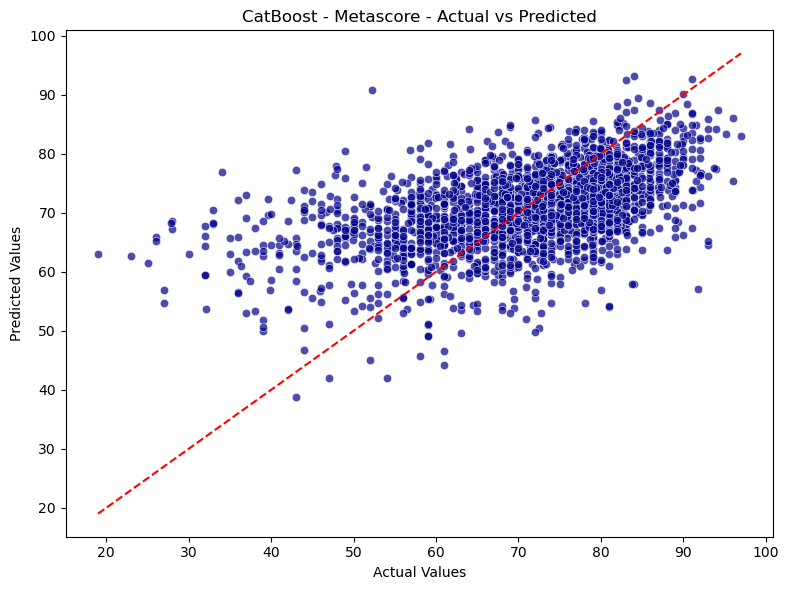

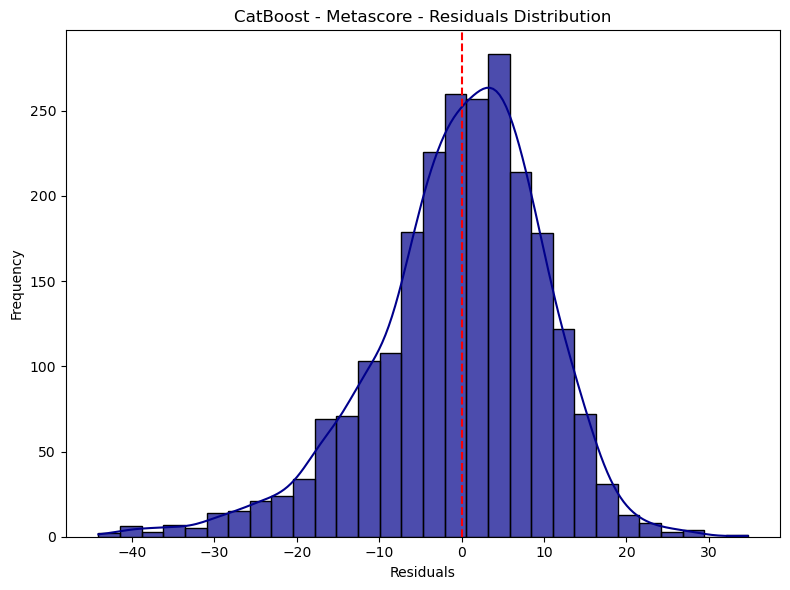

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, r2_score
from catboost import CatBoostRegressor

# Best CatBoost parameters for Metascore
cat_meta_model = CatBoostRegressor(depth=6, iterations=5000, learning_rate=0.1, random_state=42, verbose=0)
cat_meta_model.fit(X_train, y_train_meta)

# Predictions and metrics
y_pred_meta = cat_meta_model.predict(X_test)
mae_meta = mean_absolute_error(y_test_meta, y_pred_meta)
r2_meta = r2_score(y_test_meta, y_pred_meta)
print(f"CatBoost - Metascore - Test MAE: {mae_meta:.4f}, Test R²: {r2_meta:.4f}")

# Actual vs Predicted Plot for Metascore
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_meta, y=y_pred_meta, alpha=0.7, color='darkblue')
plt.plot([y_test_meta.min(), y_test_meta.max()], [y_test_meta.min(), y_test_meta.max()], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('CatBoost - Metascore - Actual vs Predicted')
plt.tight_layout()
plt.show()

# Residuals Distribution Plot for Metascore
residuals_meta = y_test_meta - y_pred_meta
plt.figure(figsize=(8, 6))
sns.histplot(residuals_meta, kde=True, bins=30, color='darkblue', alpha=0.7)
plt.axvline(x=0, color='red', linestyle='--')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('CatBoost - Metascore - Residuals Distribution')
plt.tight_layout()
plt.show()

* Userscore

CatBoost - Userscore - Test MAE: 8.7698, Test R²: 0.1627


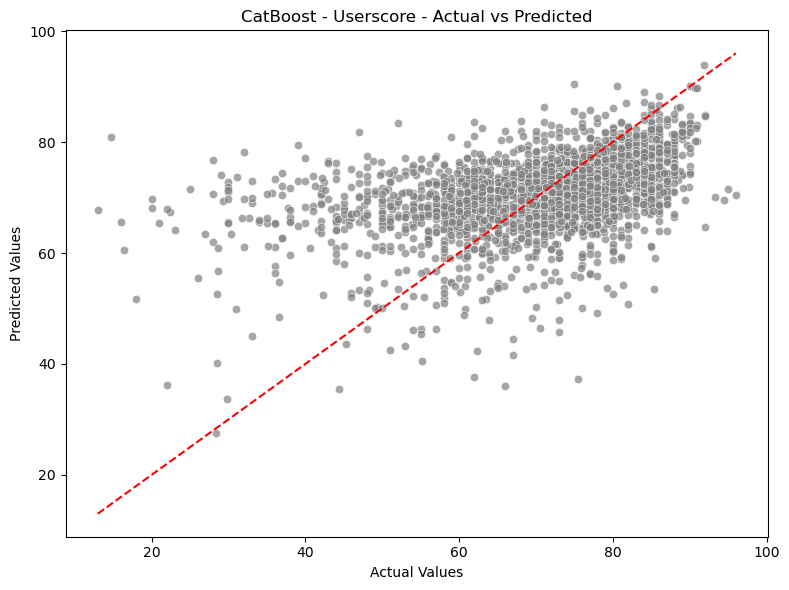

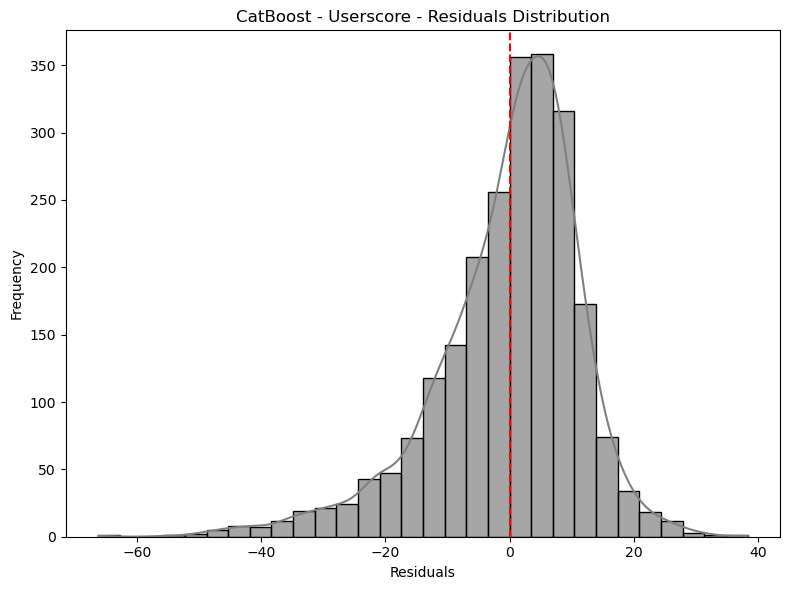

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, r2_score
from catboost import CatBoostRegressor

# Best CatBoost parameters for Userscore
cat_user_model = CatBoostRegressor(depth=6, iterations=5000, learning_rate=0.1, random_state=42, verbose=0)
cat_user_model.fit(X_train, y_train_user)

# Predictions and metrics
y_pred_user = cat_user_model.predict(X_test)
mae_user = mean_absolute_error(y_test_user, y_pred_user)
r2_user = r2_score(y_test_user, y_pred_user)
print(f"CatBoost - Userscore - Test MAE: {mae_user:.4f}, Test R²: {r2_user:.4f}")

# Actual vs Predicted Plot for Userscore
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_user, y=y_pred_user, alpha=0.7, color='gray')
plt.plot([y_test_user.min(), y_test_user.max()], [y_test_user.min(), y_test_user.max()], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('CatBoost - Userscore - Actual vs Predicted')
plt.tight_layout()
plt.show()

# Residuals Distribution Plot for Userscore
residuals_user = y_test_user - y_pred_user
plt.figure(figsize=(8, 6))
sns.histplot(residuals_user, kde=True, bins=30, color='gray', alpha=0.7)
plt.axvline(x=0, color='red', linestyle='--')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('CatBoost - Userscore - Residuals Distribution')
plt.tight_layout()
plt.show()

## **8-SHAP Values**

Calculating SHAP values for CatBoost - Metascore...
Generating SHAP summary plot for CatBoost - Metascore...


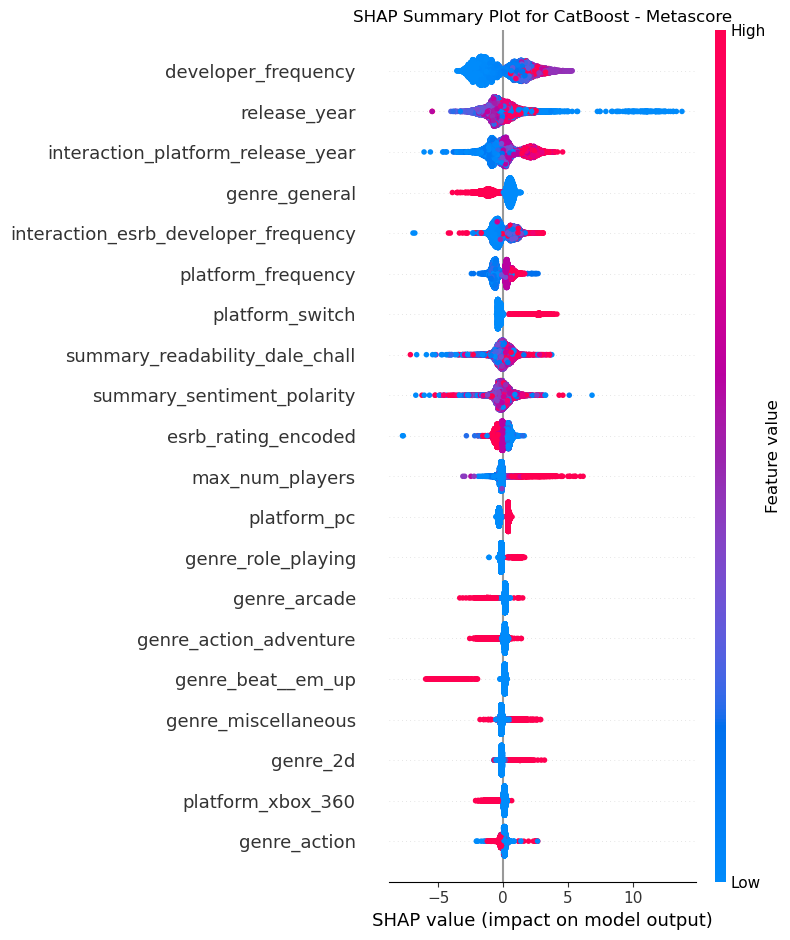

Calculating SHAP values for CatBoost - Userscore...
Generating SHAP summary plot for CatBoost - Userscore...


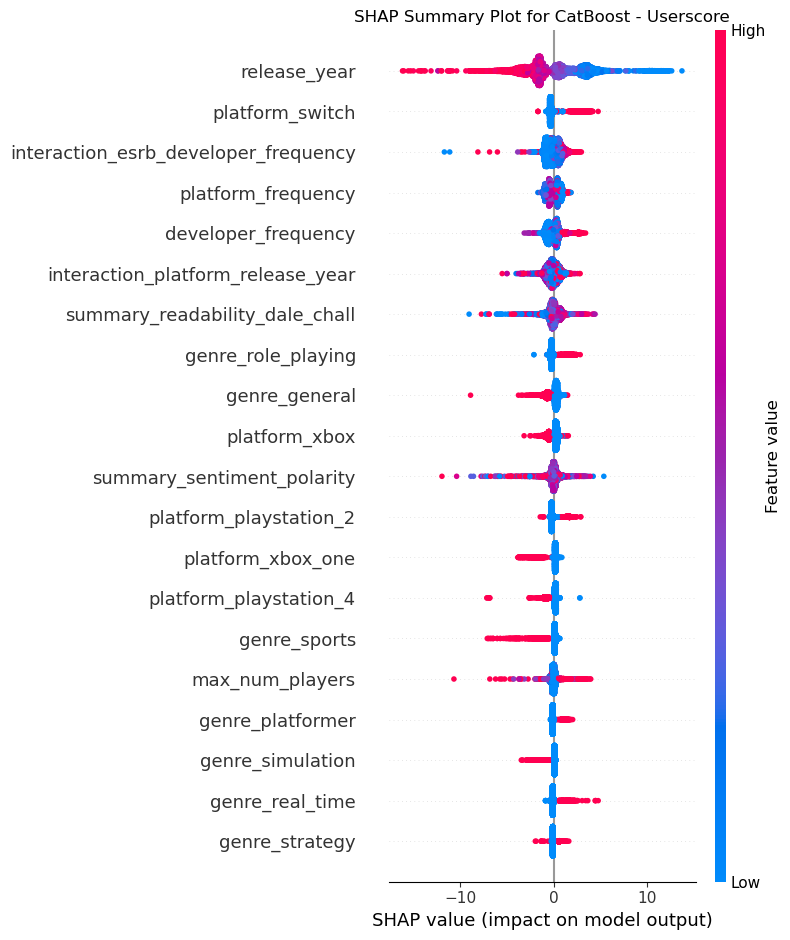

In [71]:
from catboost import Pool
import shap
import matplotlib.pyplot as plt

# Function to compute and display SHAP summary plot using CatBoost's internal SHAP
def plot_catboost_shap_summary(model, X, target_name, model_name):
    print(f"Calculating SHAP values for {model_name} - {target_name}...")

    # Use CatBoost's built-in SHAP feature importance
    shap_values = model.get_feature_importance(
        data=Pool(X),  # Correctly use catboost.Pool
        type="ShapValues"
    )

    # The last column in CatBoost SHAP values is the base value
    shap_values = shap_values[:, :-1]  # Exclude the base value

    # SHAP summary plot
    print(f"Generating SHAP summary plot for {model_name} - {target_name}...")
    shap.summary_plot(shap_values, X, show=False)
    plt.title(f"SHAP Summary Plot for {model_name} - {target_name}")
    plt.tight_layout()
    plt.show()

# Initialize CatBoost models with best parameters
cat_meta_model = CatBoostRegressor(depth=6, iterations=5000, learning_rate=0.1, random_state=42, verbose=0)
cat_user_model = CatBoostRegressor(depth=6, iterations=4000, learning_rate=0.1, random_state=42, verbose=0)

# Train models on respective datasets
cat_meta_model.fit(X_train, y_train_meta)
cat_user_model.fit(X_train, y_train_user)

# Generate SHAP summary plots using CatBoost's built-in functionality
plot_catboost_shap_summary(cat_meta_model, X_train, "Metascore", "CatBoost")
plot_catboost_shap_summary(cat_user_model, X_train, "Userscore", "CatBoost")

## Aggregated SHAP Values for original features

Calculating SHAP values for Metascore using CatBoost...
Aggregating SHAP values for Metascore...
Plotting aggregated SHAP summary plot for Metascore...


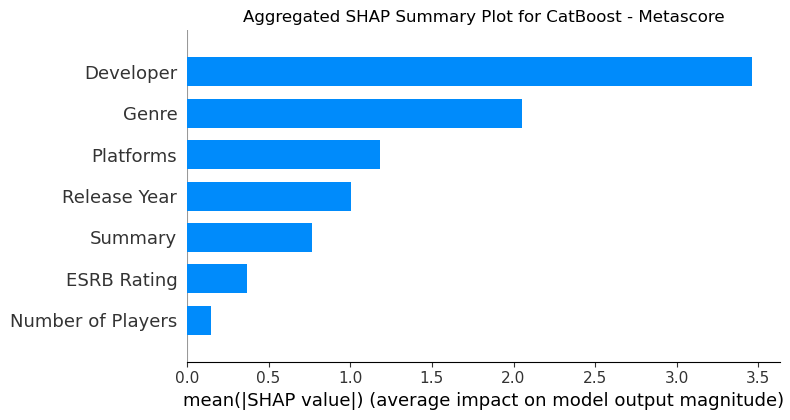

Calculating SHAP values for Userscore using CatBoost...
Aggregating SHAP values for Userscore...
Plotting aggregated SHAP summary plot for Userscore...


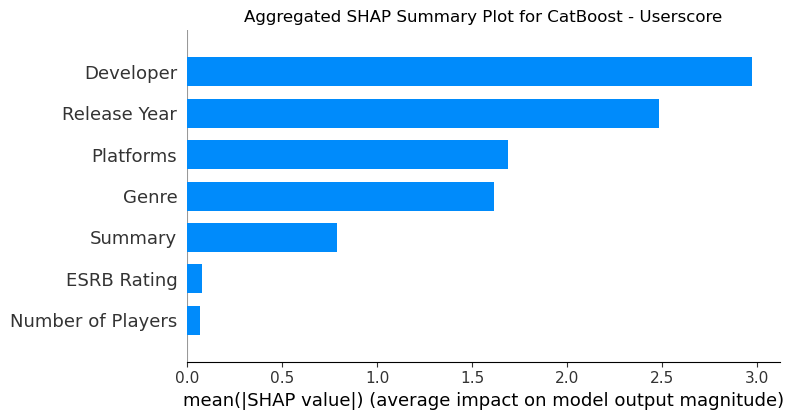

In [65]:
import shap
import pandas as pd
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor

# Initialize best models with the best parameters for both targets
best_meta_model = CatBoostRegressor(
    depth=6,
    iterations=5000,
    learning_rate=0.1,
    verbose=0,
    random_state=42
)
best_meta_model.fit(X_train, y_train_meta)

best_user_model = CatBoostRegressor(
    depth=6,
    iterations=5000,
    learning_rate=0.1,
    verbose=0,
    random_state=42
)
best_user_model.fit(X_train, y_train_user)

# Define feature groups for aggregation
feature_groups = {
    'Release Year': ['release_year'],
    'Genre': [col for col in X_train.columns if col.startswith('genre_')],
    'Platforms': [col for col in X_train.columns if col.startswith('platform_')],
    'Developer': [col for col in X_train.columns if col.startswith('developer_')],
    'ESRB Rating': [col for col in X_train.columns if col.startswith('esrb_rating_')],
    'Number of Players': [col for col in X_train.columns if col.startswith('num_players_')],
    'Summary': [col for col in X_train.columns if col.startswith('summary_')]
}

# Function to aggregate SHAP values
def aggregate_shap_values(shap_values, X, feature_groups):
    shap_df = pd.DataFrame(shap_values, columns=X.columns)
    aggregated_shap = pd.DataFrame(index=shap_df.index)

    for original_feature, group_columns in feature_groups.items():
        if group_columns:  # Check if group_columns are not empty
            aggregated_shap[original_feature] = shap_df[group_columns].sum(axis=1)  # Sum SHAP values for each group
    
    return aggregated_shap

# Function to generate aggregated SHAP summary plot
def plot_aggregated_shap_summary(model, X, target_name, feature_groups, model_name):
    print(f"Calculating SHAP values for {target_name} using {model_name}...")

    # Use CatBoost's TreeExplainer for SHAP values
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)

    # Aggregate SHAP values
    print(f"Aggregating SHAP values for {target_name}...")
    aggregated_shap = aggregate_shap_values(shap_values, X, feature_groups)

    # Create a bar plot for aggregated SHAP values
    print(f"Plotting aggregated SHAP summary plot for {target_name}...")
    shap.summary_plot(
        aggregated_shap.values, 
        features=aggregated_shap.columns, 
        plot_type="bar",
        show=False
    )
    plt.title(f"Aggregated SHAP Summary Plot for {model_name} - {target_name}")
    plt.tight_layout()
    plt.show()

# Generate plots for Metascore and Userscore
# Metascore (CatBoost)
plot_aggregated_shap_summary(best_meta_model, X_train, "Metascore", feature_groups, "CatBoost")

# Userscore (CatBoost)
plot_aggregated_shap_summary(best_user_model, X_train, "Userscore", feature_groups, "CatBoost")